# Downscaling using Scipy Interpolate

This is bilinear interpolation which takes 2 cells on both left and right

In [8]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import dask.array as da

file_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 2020\data files\202001.nc'  # <-- Load nc file
dataset = xr.open_dataset(file_path, chunks={'time': 10})  # Adjust chunk size based on memory

variable = dataset['precipitation'].transpose('time', 'lat', 'lon')

time_values = variable['time'].values
lat_values = variable['lat'].values
lon_values = variable['lon'].values

# Define the spatial downscaling factor
spatial_factor = 5  # to get ~2km resolution

# Perform spatial downscaling
lat_new = np.linspace(lat_values.min(), lat_values.max(), len(lat_values) * spatial_factor)
lon_new = np.linspace(lon_values.min(), lon_values.max(), len(lon_values) * spatial_factor)

def spatial_interpolate(data_chunk, lat_values, lon_values, lat_new, lon_new):
    interpolated_chunk = np.zeros((data_chunk.shape[0], len(lat_new), len(lon_new)))
    for t in range(data_chunk.shape[0]):
        interpolator = RegularGridInterpolator((lat_values, lon_values), data_chunk[t], bounds_error=False, fill_value=None)
        lat_grid, lon_grid = np.meshgrid(lat_new, lon_new, indexing='ij')
        points = np.array([lat_grid.flatten(), lon_grid.flatten()]).T
        interpolated_chunk[t] = interpolator(points).reshape(len(lat_new), len(lon_new))
    return interpolated_chunk

# Apply the interpolation function lazily using Dask
spatial_downscaled_data = da.map_blocks(spatial_interpolate, variable.data, lat_values, lon_values, lat_new, lon_new, dtype=float)

# Ensure Dask computations are completed before saving
spatial_downscaled_data = spatial_downscaled_data.compute()

# Create a new xarray dataset for the downscaled data
downscaled_dataset = xr.Dataset(
    {'precipitation': (['time', 'lat', 'lon'], spatial_downscaled_data)},
    coords={
        'time': time_values,
        'lat': lat_new,
        'lon': lon_new
    }
)

# Save the downscaled data to a new NetCDF file
output_file_path = 'c:\\Users\\userAdmin\\Desktop\\downscaled_combined_data_bilinear.nc'
downscaled_dataset.to_netcdf(output_file_path)

print(f"Downscaled data saved to {output_file_path}")


Downscaled data saved to c:\Users\userAdmin\Desktop\downscaled_combined_data_bilinear.nc


Scipy nearest neighbour

In [9]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import dask.array as da

file_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 2020\data files\202001.nc'  # <-- Load nc file
dataset = xr.open_dataset(file_path, chunks={'time': 10})  # Adjust chunk size based on memory

variable = dataset['precipitation'].transpose('time', 'lat', 'lon')

time_values = variable['time'].values
lat_values = variable['lat'].values
lon_values = variable['lon'].values

# Define the spatial downscaling factor
spatial_factor = 5  # to get ~2km resolution

# Perform spatial downscaling
lat_new = np.linspace(lat_values.min(), lat_values.max(), len(lat_values) * spatial_factor)
lon_new = np.linspace(lon_values.min(), lon_values.max(), len(lon_values) * spatial_factor)

def spatial_interpolate(data_chunk, lat_values, lon_values, lat_new, lon_new):
    interpolated_chunk = np.zeros((data_chunk.shape[0], len(lat_new), len(lon_new)))
    for t in range(data_chunk.shape[0]):
        interpolator = RegularGridInterpolator((lat_values, lon_values), data_chunk[t], method='cubic', bounds_error=False, fill_value=None)
        lat_grid, lon_grid = np.meshgrid(lat_new, lon_new, indexing='ij')
        points = np.array([lat_grid.flatten(), lon_grid.flatten()]).T
        interpolated_chunk[t] = interpolator(points).reshape(len(lat_new), len(lon_new))
    return interpolated_chunk

# Apply the interpolation function lazily using Dask
spatial_downscaled_data = da.map_blocks(spatial_interpolate, variable.data, lat_values, lon_values, lat_new, lon_new, dtype=float)

# Ensure Dask computations are completed before saving
spatial_downscaled_data = spatial_downscaled_data.compute()

# Create a new xarray dataset for the downscaled data
downscaled_dataset = xr.Dataset(
    {'precipitation': (['time', 'lat', 'lon'], spatial_downscaled_data)},
    coords={
        'time': time_values,
        'lat': lat_new,
        'lon': lon_new
    }
)

# Save the downscaled data to a new NetCDF file
output_file_path = 'c:\\Users\\userAdmin\\Desktop\\downscaled_combined_data_cubic.nc'
downscaled_dataset.to_netcdf(output_file_path)

print(f"Downscaled data saved to {output_file_path}")


Downscaled data saved to c:\Users\userAdmin\Desktop\downscaled_combined_data_cubic.nc


Evaluation tools

In [3]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error
import torch
import piq

# Function to evaluate image quality
def evaluate_image_quality(A, B):
    # Mean Absolute Error (MAE)
    mae_value = mae(A.flatten(), B.flatten())

    # Root Mean Square Error (RMSE)
    rmse_value = np.sqrt(mean_squared_error(A.flatten(), B.flatten()))

    # Peak Signal-to-Noise Ratio (PSNR)
    psnr_value = psnr(A, B, data_range=A.max() - A.min())

    # Structural Similarity Index (SSIM)
    ssim_value = ssim(A, B, data_range=A.max() - A.min())

    # Normalize images to [0, 1] range for piq metrics
    A_norm = (A - np.min(A)) / (np.max(A) - np.min(A))
    B_norm = (B - np.min(B)) / (np.max(B) - np.min(B))

    # Convert images to PyTorch tensors for piq metrics
    A_tensor = torch.tensor(A_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    B_tensor = torch.tensor(B_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Multi-Scale Structural Similarity Index (MS-SSIM)
    ms_ssim_value = piq.multi_scale_ssim(A_tensor, B_tensor, data_range=1.0).item()

    # Gradient Magnitude Similarity Deviation (GMSD)
    gmsd_value = piq.gmsd(A_tensor, B_tensor, data_range=1.0).item()

    # Print the results
    print(f'MAE: {mae_value}')
    print(f'RMSE: {rmse_value}')
    print(f'PSNR: {psnr_value}')
    print(f'SSIM: {ssim_value}')
    print(f'MS-SSIM: {ms_ssim_value}')
    print(f'GMSD: {gmsd_value}')

    return round(mae_value, 3), round(rmse_value, 3), round(psnr_value, 3), round(ssim_value, 3), round(ms_ssim_value, 3), round(gmsd_value, 3)

Selected time frame index: 460


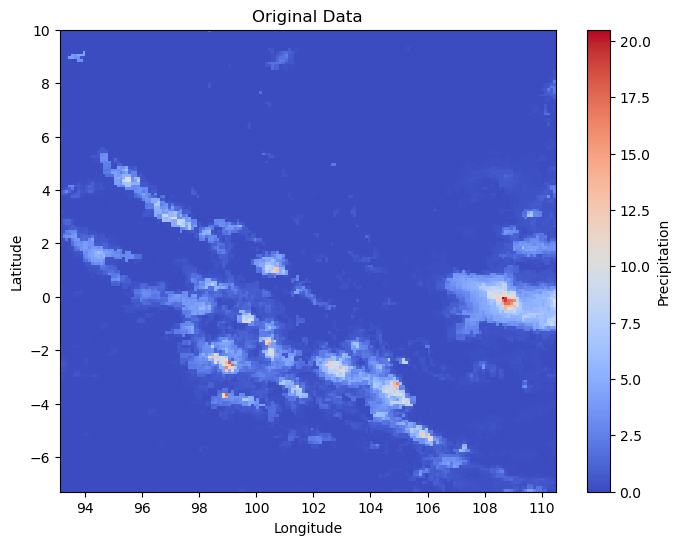

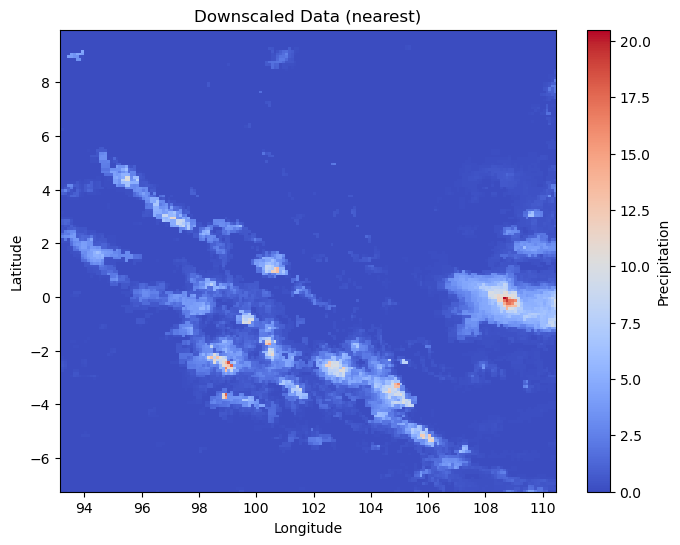

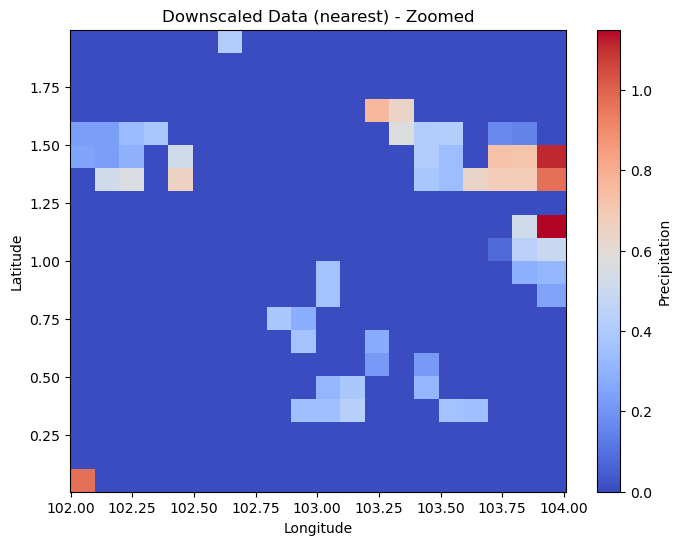

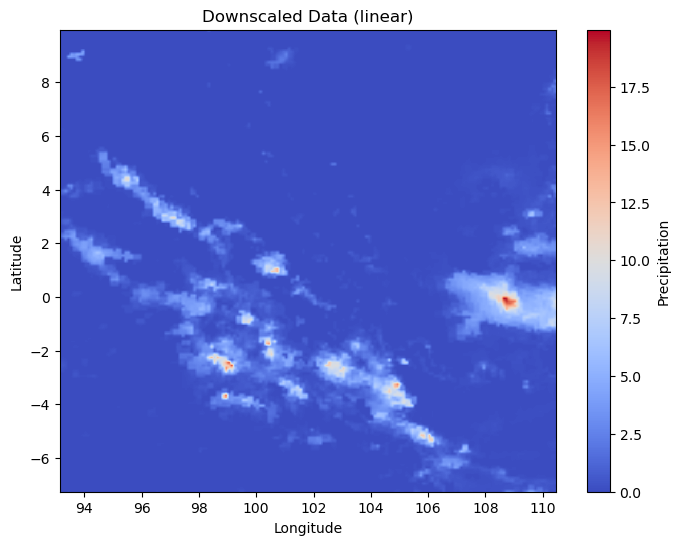

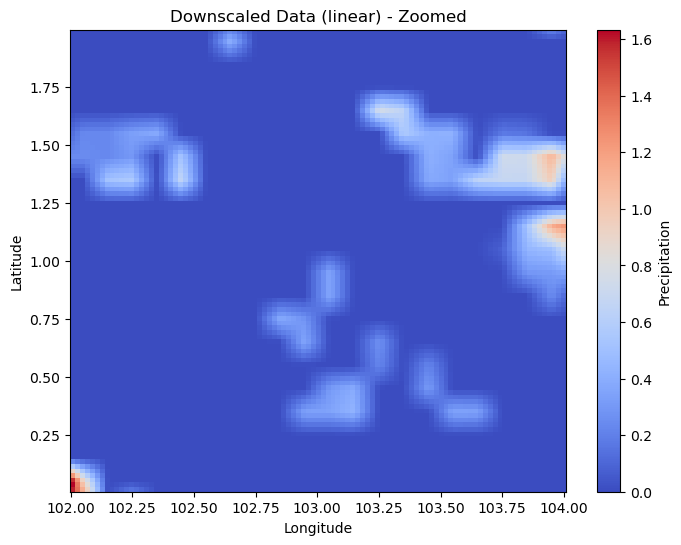

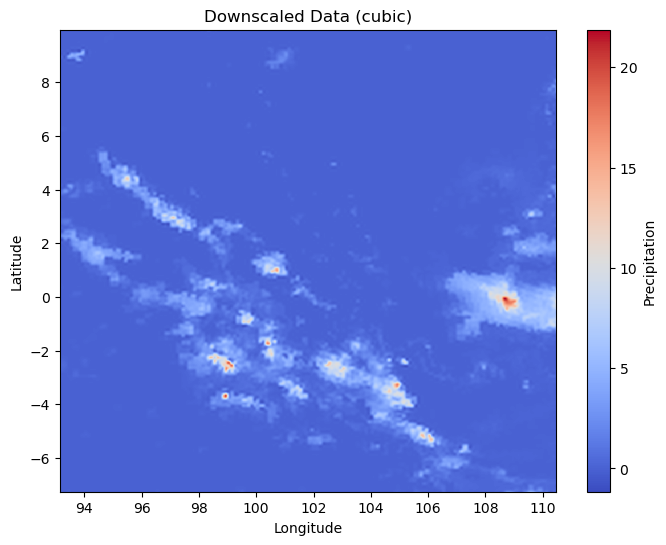

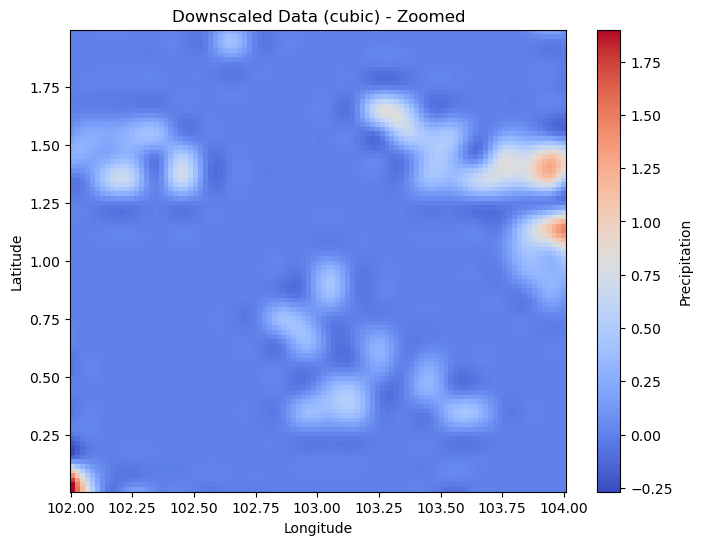

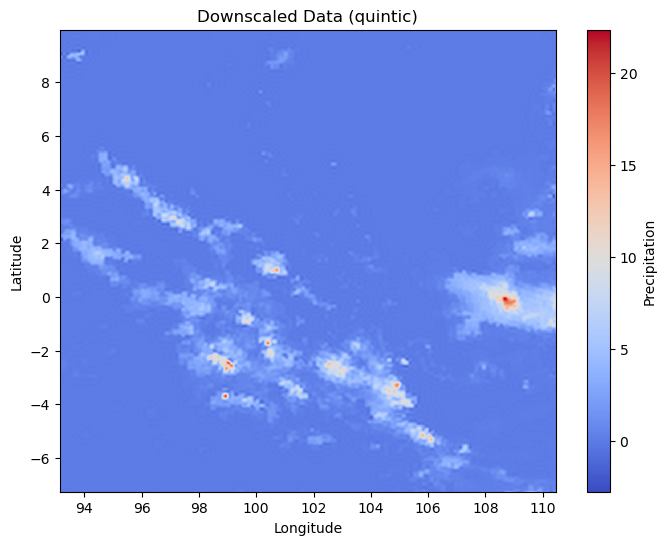

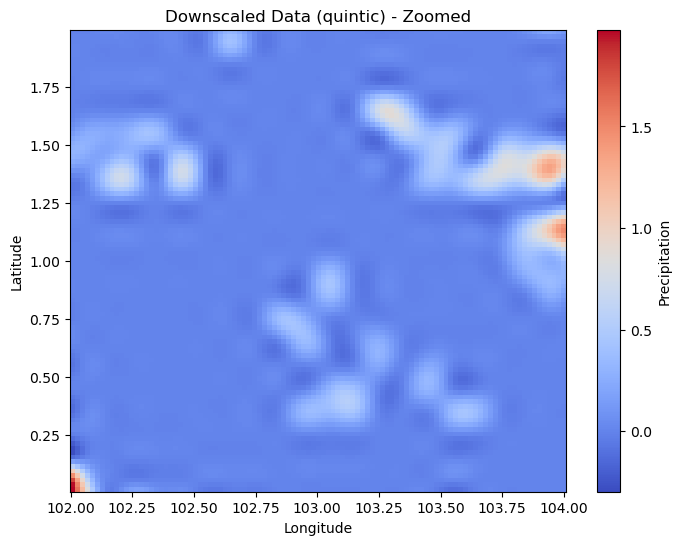

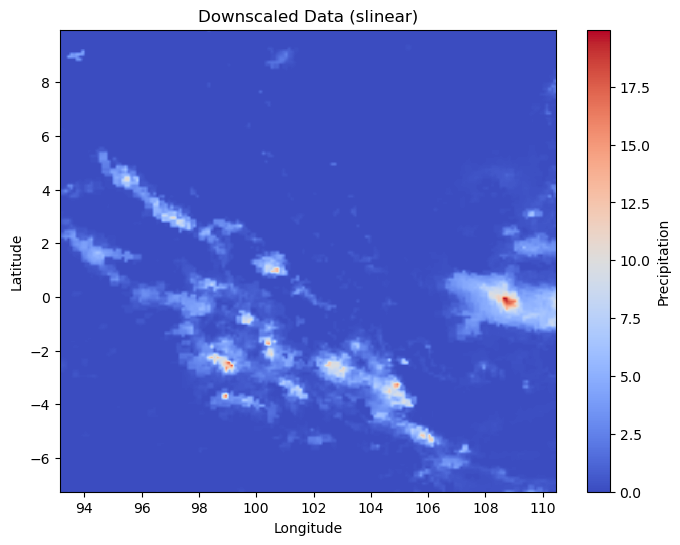

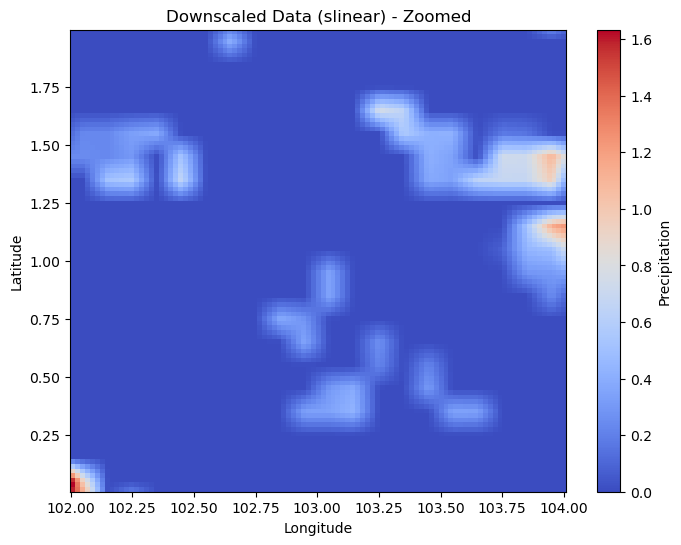

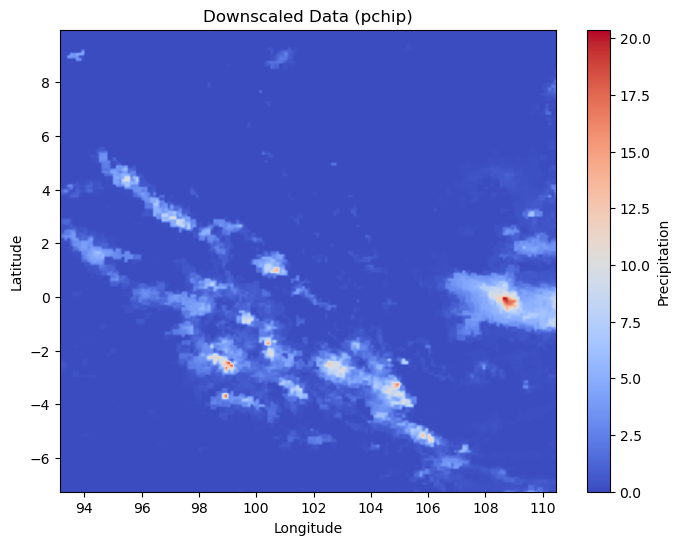

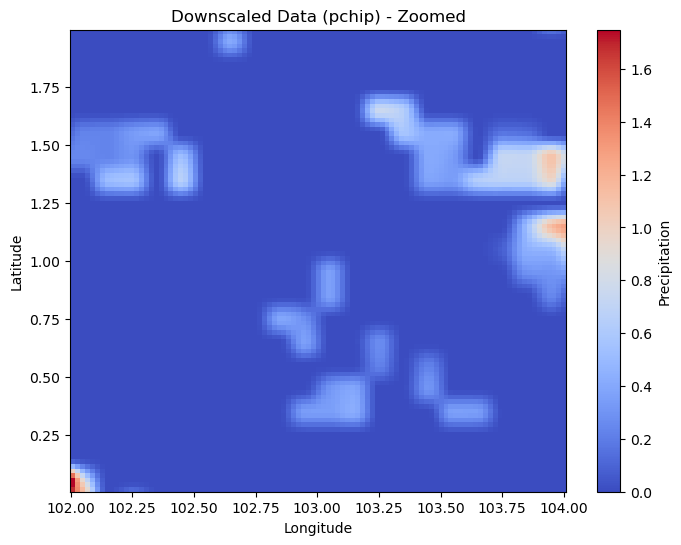

In [1]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

file_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 2020\data files\202001.nc'  # <-- Load nc file
dataset = xr.open_dataset(file_path)

variable = dataset['precipitation'].transpose('time', 'lat', 'lon')

time_values = variable['time'].values
lat_values = variable['lat'].values
lon_values = variable['lon'].values

# Select a random time frame
random_time_index = 460
print(f"Selected time frame index: {random_time_index}")
data_chunk = variable.isel(time=random_time_index).values

# Define the spatial downscaling factor
spatial_factor = 5  # to get ~2km resolution

# Perform spatial downscaling
lat_new = np.linspace(lat_values.min(), lat_values.max(), len(lat_values) * spatial_factor)
lon_new = np.linspace(lon_values.min(), lon_values.max(), len(lon_values) * spatial_factor)

def spatial_interpolate(data, lat_values, lon_values, lat_new, lon_new, method):
    interpolated_data = np.zeros((len(lat_new), len(lon_new)))
    interpolator = RegularGridInterpolator((lat_values, lon_values), data, method=method, bounds_error=False, fill_value=None)
    lat_grid, lon_grid = np.meshgrid(lat_new, lon_new, indexing='ij')
    points = np.array([lat_grid.flatten(), lon_grid.flatten()]).T
    interpolated_data = interpolator(points).reshape(len(lat_new), len(lon_new))
    return interpolated_data

methods = ['nearest', 'linear', 'cubic', 'quintic','slinear','pchip']
interpolated_results = {}

for method in methods:
    interpolated_results[method] = spatial_interpolate(data_chunk, lat_values, lon_values, lat_new, lon_new, method)

# Define zoom area
zoom_lat_min, zoom_lat_max = 0,2   # Example latitude range for zoom
zoom_lon_min, zoom_lon_max = 102, 104  # Example longitude range for zoom

# Function to plot zoomed area
def plot_zoomed_area(data, lat_new, lon_new, method, zoom_lat_min, zoom_lat_max, zoom_lon_min, zoom_lon_max):
    plt.figure(figsize=(8, 6))
    lat_mask = (lat_new >= zoom_lat_min) & (lat_new <= zoom_lat_max)
    lon_mask = (lon_new >= zoom_lon_min) & (lon_new <= zoom_lon_max)
    lat_zoom = lat_new[lat_mask]
    lon_zoom = lon_new[lon_mask]
    data_zoom = data[np.ix_(lat_mask, lon_mask)]
    plt.pcolormesh(lon_zoom, lat_zoom, data_zoom, cmap='coolwarm')
    plt.title(f'Downscaled Data ({method}) - Zoomed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Precipitation')
    plt.show()

# Plot the original data
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon_values, lat_values, data_chunk, cmap='coolwarm')
plt.title('Original Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Precipitation')
plt.show()

# Plot downscaled data for each method and zoom in
for method in methods:
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(lon_new, lat_new, interpolated_results[method], cmap='coolwarm')
    plt.title(f'Downscaled Data ({method})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Precipitation')
    plt.show()
    
    plot_zoomed_area(interpolated_results[method], lat_new, lon_new, method, zoom_lat_min, zoom_lat_max, zoom_lon_min, zoom_lon_max)


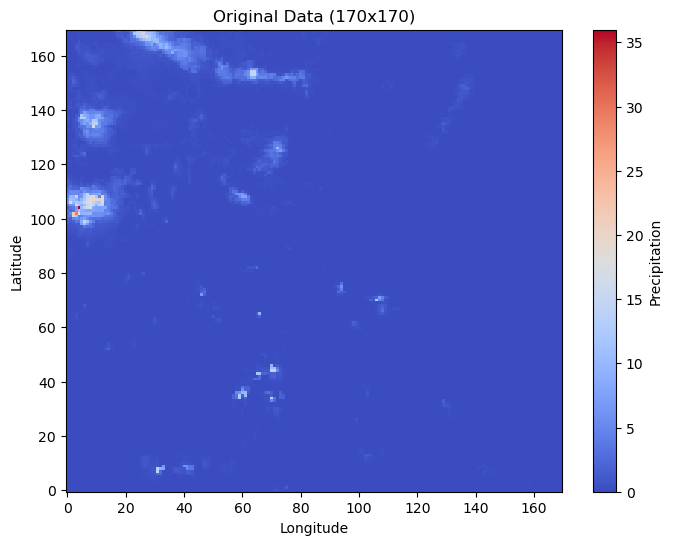

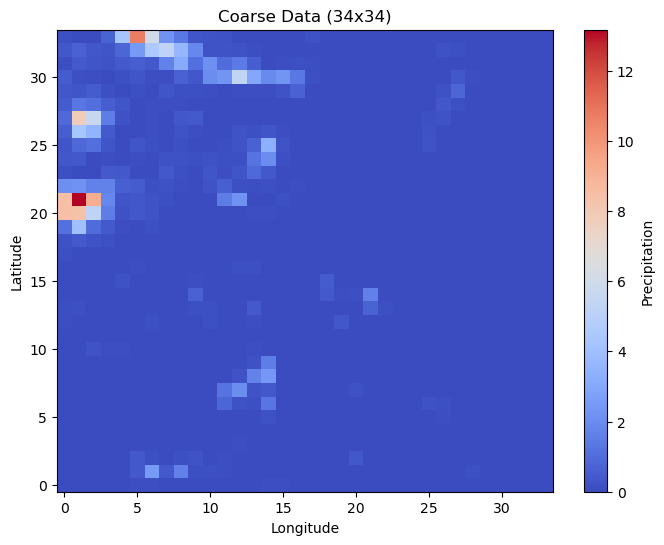


Evaluating nearest interpolation:


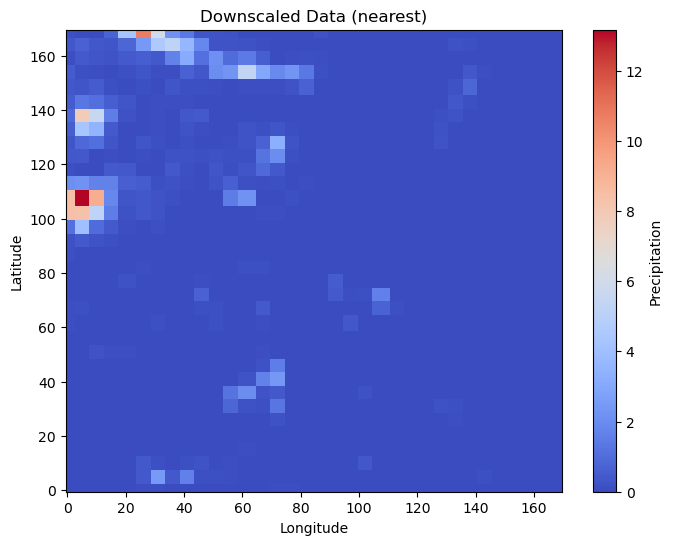


Evaluating linear interpolation:


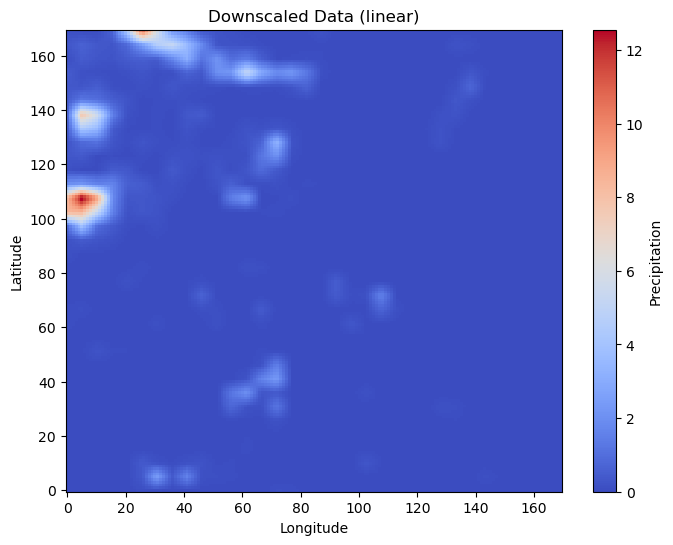


Evaluating cubic interpolation:


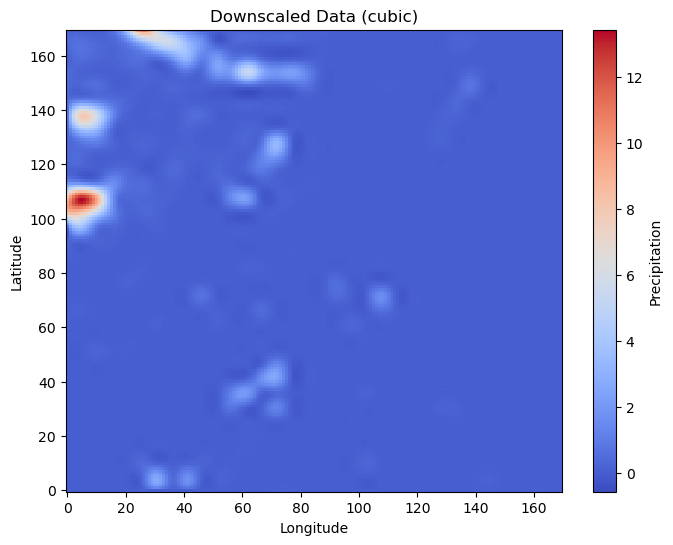


Evaluating quintic interpolation:


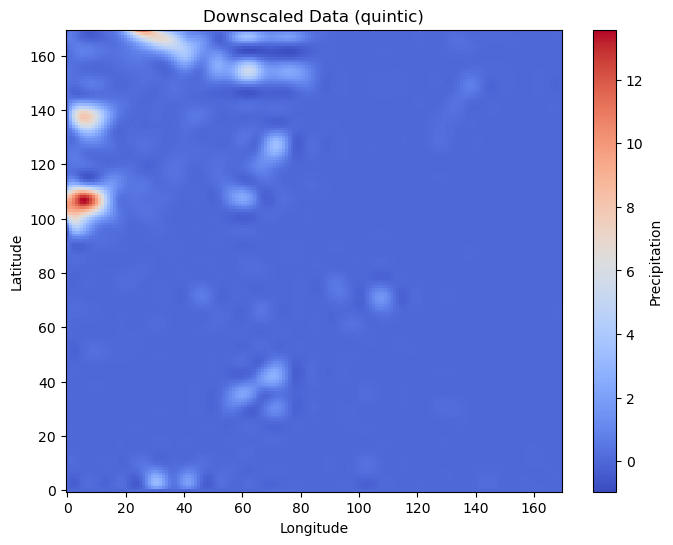


Evaluating slinear interpolation:


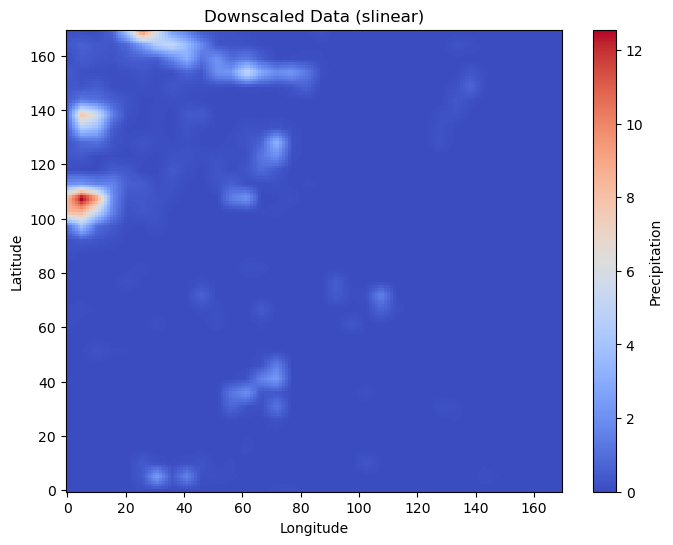


Evaluating pchip interpolation:


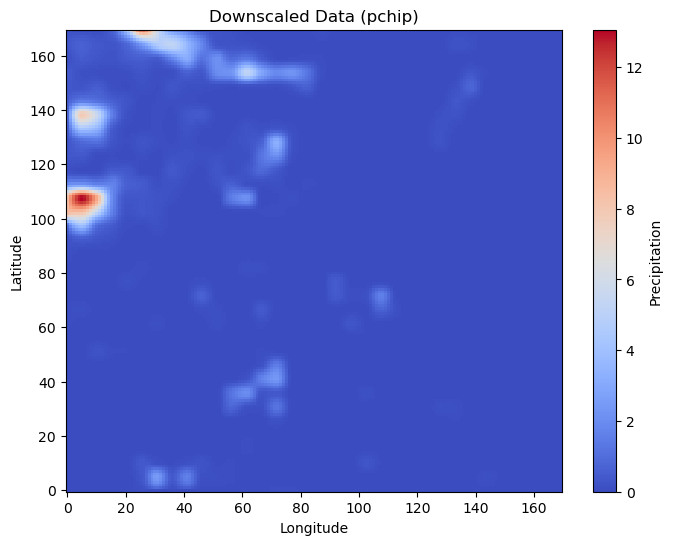

    Method       MAE      RMSE       PSNR      SSIM
0  nearest  0.150386  0.703140  34.180383  0.934062
1   linear  0.141143  0.658492  34.750212  0.939982
2    cubic  0.150975  0.659837  34.732486  0.940792
3  quintic  0.164456  0.673052  34.560246  0.935921
4  slinear  0.141143  0.658492  34.750212  0.939982
5    pchip  0.140157  0.657894  34.758103  0.942460


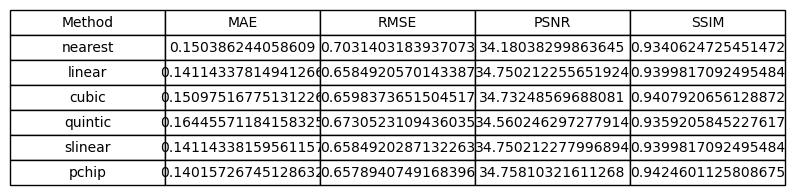

In [8]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error
import pandas as pd

# Load the nc file
file_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 2020\data files\202001.nc'
dataset = xr.open_dataset(file_path)

variable = dataset['precipitation'].values[0, :170, :170]

# Coarsen the data by averaging over spatial bins to create a coarse version
def coarsen_data(data, factor):
    lat_bins = data.shape[0] // factor
    lon_bins = data.shape[1] // factor
    coarse_data = data[:lat_bins * factor, :lon_bins * factor].reshape(lat_bins, factor, lon_bins, factor).mean(axis=(1, 3))
    return coarse_data

# Coarsen to 34x34
coarse_data = coarsen_data(variable, 5)

# Perform spatial interpolation
lat_values = np.linspace(0, variable.shape[0] - 1, variable.shape[0])
lon_values = np.linspace(0, variable.shape[1] - 1, variable.shape[1])

lat_coarse = np.linspace(0, coarse_data.shape[0] - 1, coarse_data.shape[0])
lon_coarse = np.linspace(0, coarse_data.shape[1] - 1, coarse_data.shape[1])

lat_new = np.linspace(lat_coarse.min(), lat_coarse.max(), len(lat_values))
lon_new = np.linspace(lon_coarse.min(), lon_coarse.max(), len(lon_values))

def spatial_interpolate(data, lat_values, lon_values, lat_new, lon_new, method):
    interpolator = RegularGridInterpolator((lat_values, lon_values), data, method=method, bounds_error=False, fill_value=None)
    lat_grid, lon_grid = np.meshgrid(lat_new, lon_new, indexing='ij')
    points = np.array([lat_grid.flatten(), lon_grid.flatten()]).T
    interpolated_data = interpolator(points).reshape(len(lat_new), len(lon_new))
    return interpolated_data

methods = ['nearest', 'linear', 'cubic', 'quintic', 'slinear', 'pchip']
interpolated_results = {}
metrics = []

def evaluate_image_quality(original, downscaled):
    data_range = original.max() - original.min()
    mae_value = mae(original, downscaled)
    rmse_value = np.sqrt(mean_squared_error(original, downscaled))
    psnr_value = psnr(original, downscaled, data_range=data_range)
    ssim_value = ssim(original, downscaled, data_range=data_range)
    return mae_value, rmse_value, psnr_value, ssim_value

for method in methods:
    interpolated_results[method] = spatial_interpolate(coarse_data, lat_coarse, lon_coarse, lat_new, lon_new, method)

# Plot the original data
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon_values, lat_values, variable, cmap='coolwarm')
plt.title('Original Data (170x170)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Precipitation')
plt.show()

# Plot coarse data
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon_coarse, lat_coarse, coarse_data, cmap='coolwarm')
plt.title('Coarse Data (34x34)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Precipitation')
plt.show()

# Function to plot zoomed area
def plot_zoomed_area(data, lat_new, lon_new, method, zoom_lat_min, zoom_lat_max, zoom_lon_min, zoom_lon_max):
    plt.figure(figsize=(8, 6))
    lat_mask = (lat_new >= zoom_lat_min) & (lat_new <= zoom_lat_max)
    lon_mask = (lon_new >= zoom_lon_min) & (lon_new <= zoom_lon_max)
    if lat_mask.sum() == 0 or lon_mask.sum() == 0:
        print(f"Zoom range for method {method} results in an empty slice. Adjusting zoom range.")
        return
    lat_zoom = lat_new[lat_mask]
    lon_zoom = lon_new[lon_mask]
    data_zoom = data[np.ix_(lat_mask, lon_mask)]
    plt.pcolormesh(lon_zoom, lat_zoom, data_zoom, cmap='coolwarm')
    plt.title(f'Downscaled Data ({method}) - Zoomed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Precipitation')
    plt.show()

for method in methods:
    print(f"\nEvaluating {method} interpolation:")
    mae_value, rmse_value, psnr_value, ssim_value = evaluate_image_quality(variable, interpolated_results[method])
    metrics.append([method, mae_value, rmse_value, psnr_value, ssim_value])

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(lon_values, lat_values, interpolated_results[method], cmap='coolwarm')
    plt.title(f'Downscaled Data ({method})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Precipitation')
    plt.show()

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame(metrics, columns=['Method', 'MAE', 'RMSE', 'PSNR', 'SSIM'])
print(metrics_df)

# Display metrics in a table
plt.figure(figsize=(10, 2))
plt.axis('off')
tbl = plt.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
tbl.scale(1, 1.5)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
plt.show()
